In [19]:
from inference.run_inference import scrape_and_predict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sentiment_model.evaluation import run_evaluation
import pandas as pd
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sentiment_model.data_utils.tweet_dataset import tokenize, process_token_list
from tqdm.notebook import tqdm

## Model evaluation

In [2]:
predictions, targets = run_evaluation()

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Test set accuracy: 0.7164686322212219


In [3]:
def create_test_df(preds, targets):
    preds = np.argmax(preds, axis=1)
    labels = ['negative', 'neutral', 'positive']
    text_labels = [labels[int(i)] for i in preds]
    target_labels = [labels[int(i)] for i in targets]

    return pd.DataFrame({"target": target_labels, "predictions": text_labels})

test_df = create_test_df(predictions, targets)

In [4]:
def plot_bar(df, x_col, y_col):
    fig, ax = plt.subplots(1,1)
    ax.plot(df[x_col], df[y_col])

    return

def plot_label_count(df):
    counts = [np.sum(np.array(df['target']) == i) for i in np.unique(df['target'])]

    fig, ax = plt.subplots(1,1)

    ax.bar(np.unique(df['target']), counts)

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    labels = ['negative', 'neutral', 'positive']
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)


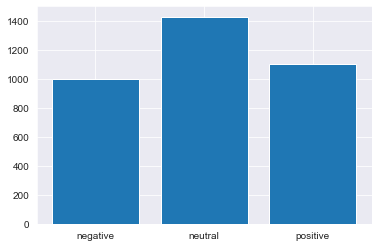

In [5]:
plot_label_count(test_df)

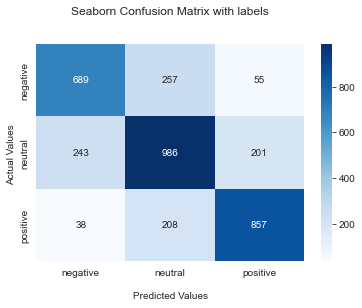

In [6]:
plot_confusion_matrix(confusion_matrix(test_df['target'], test_df['predictions']))

## Scrape and predict sentiment

In [7]:
sentiment, text_sentiment, tweet_df = scrape_and_predict()

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

1001it [01:11, 13.94it/s]                         


  0%|          | 0/1001 [00:00<?, ?it/s]

In [8]:
tweet_df['sentiment_label'] = text_sentiment
tweet_df['text_length'] = [len(text) for text in tweet_df['rawContent']]

In [56]:
def plot_sentiment(tweet_df):
    sent_cl = np.unique(tweet_df["sentiment_label"])

    counts = [np.sum(np.array(tweet_df['sentiment_label']) == cl) for cl in sent_cl]

    fig, ax = plt.subplots(1,1)

    ax.bar(sent_cl, counts)
    return

def plot_text_lengths(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'negative'], shade=True, color="r", ax=ax, label="negative")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'neutral'], shade=True, color="b", ax=ax, label="neutral")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'positive'], shade=True, color="g", ax=ax, label="positive")
    ax.set_xlim(-10, 400)
    ax.legend()
    ax.set_title("Text length per sentiment label")

def plot_date_dist(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.histplot(tweet_df['date'], ax=ax)

    ax.tick_params(axis='x', rotation=60)
    ax.set_title("Tweet frequency over time")

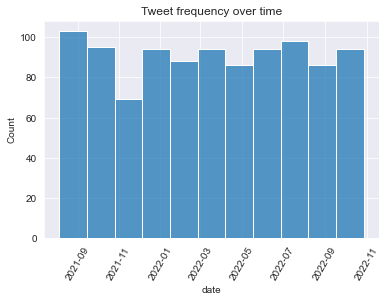

In [57]:
plot_date_dist(tweet_df)

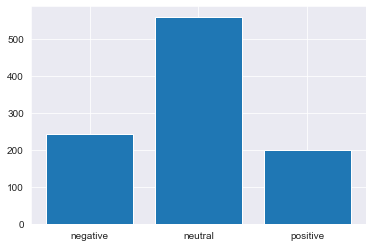

In [10]:
plot_sentiment(tweet_df)

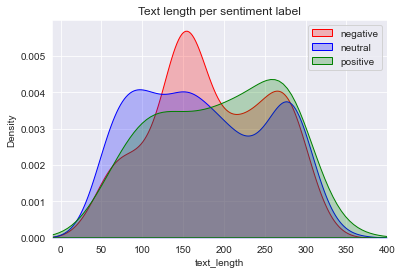

In [11]:
plot_text_lengths(tweet_df)

In [29]:
def get_word_cloud_text(tweet_df):
    tweet_tokens = []
    for tweet in tqdm(tweet_df['rawContent']):
        tweet_tokens.extend(tokenize(tweet))

    return " ".join(token for token in tweet_tokens)


def get_word_cloud_text(tweet_df):
    all_tweets = " ".join(tweet for tweet in tweet_df['rawContent'])
    all_tweets_tokens = process_token_list(tokenize(all_tweets))
    return " ".join(token for token in all_tweets_tokens)


def plot_word_cloud(tweet_df, sentiment_class=None):
    stopwords = set(STOPWORDS)
    stopwords.update({"<url>", "<user>", "user", "s", "url", "hashtag"})
    word_cloud = WordCloud(stopwords=stopwords, min_word_length=2)

    if not sentiment_class:
        text = get_word_cloud_text(tweet_df)
    else:
        text = get_word_cloud_text(tweet_df[tweet_df['sentiment_label'] == sentiment_class])

    word_cloud.generate(text)

    fig, ax = plt.subplots(1,1)
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")
    plt.show()



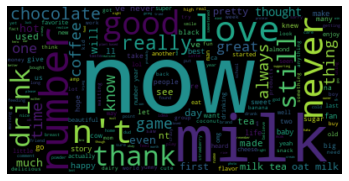

In [30]:
plot_word_cloud(tweet_df, "positive")

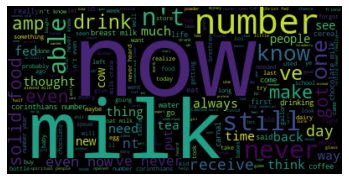

In [31]:
plot_word_cloud(tweet_df, "neutral")

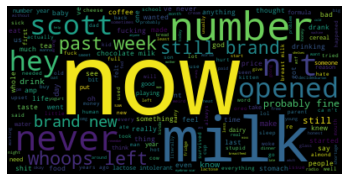

In [32]:
plot_word_cloud(tweet_df, "negative")